In [1]:
__depends__ = [
    "../../../data/database-results/phase-1/timestamp.txt",
    "../../../data/database-observations/timestamp.txt",
]
__dest__ = [
    "../../../figures/rcp-ssp-comparison.pdf",
    "../../../figures/rcp-ssp-emissions-comparison.pdf",
]

In [2]:
TAS_COMPARISON_FIGURE_PDF = __dest__[0]
EMMS_COMPARISON_FIGURE_PDF = __dest__[1]

In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# RCP SSP comparisons

In [4]:
import glob
import logging

import os

import re
from pathlib import Path

import numpy as np
import pandas as pd
import pyam

import tqdm

from pymagicc.io import MAGICCData
from scmdata import df_append, ScmDataFrame

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.gridspec as gridspec
import seaborn as sns

%matplotlib inline

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
from utils import (
    aggregate_effective_aerosol_forcing,
    clean_labels,
    convert_scmdf_to_pyamdf_year_only,
    load_database_files,
    prep_str_for_filename,
    reduce_to_one_variant_per_model,
)

<IPython.core.display.Javascript object>

In [6]:
logger = logging.getLogger()

<IPython.core.display.Javascript object>

In [7]:
color_map_scenarios_base = {
    "ssp119": "AR6-SSP1-1.9",
    "ssp126": "AR6-SSP1-2.6",
    "ssp245": "AR6-SSP2-4.5",
    "ssp370": "AR6-SSP3-7.0",
    "ssp370-lowNTCF": "AR6-SSP3-LowNTCF",
    "ssp370-lowNTCF-gidden": "AR6-SSP3-LowNTCF",
    "ssp370-lowNTCF-aerchemmip": "AR6-SSP3-LowNTCF",
    "ssp434": "AR6-SSP4-3.4",
    "ssp460": "AR6-SSP4-6.0",
    "ssp585": "AR6-SSP5-8.5",
    "ssp534-over": "AR6-SSP5-3.4-OS",
    "historical": "black",
    "rcp26": "AR5-RCP-2.6",
    "rcp45": "AR5-RCP-4.5",
    "rcp60": "AR5-RCP-6.0",
    "rcp85": "AR5-RCP-8.5",
    "historical-cmip5": "tab:gray",
}

color_map_scenarios = {}
for k, v in color_map_scenarios_base.items():
    color_map_scenarios[k] = v
    color_map_scenarios["esm-{}".format(k)] = v
    color_map_scenarios["esm-{}-allGHG".format(k)] = v

pyam.run_control().update({"color": {"scenario": color_map_scenarios}})

<IPython.core.display.Javascript object>

In [8]:
color_map_scenarios_hex = {}
for k, v in color_map_scenarios.items():
    try:
        color_map_scenarios_hex[k] = pyam.plotting.PYAM_COLORS[v]
    except KeyError:
        color_map_scenarios_hex[k] = v

color_map_scenarios_hex

{'ssp119': '#00AAD0',
 'esm-ssp119': '#00AAD0',
 'esm-ssp119-allGHG': '#00AAD0',
 'ssp126': '#003466',
 'esm-ssp126': '#003466',
 'esm-ssp126-allGHG': '#003466',
 'ssp245': '#EF550F',
 'esm-ssp245': '#EF550F',
 'esm-ssp245-allGHG': '#EF550F',
 'ssp370': '#E00000',
 'esm-ssp370': '#E00000',
 'esm-ssp370-allGHG': '#E00000',
 'ssp370-lowNTCF': '#E00000',
 'esm-ssp370-lowNTCF': '#E00000',
 'esm-ssp370-lowNTCF-allGHG': '#E00000',
 'ssp370-lowNTCF-gidden': '#E00000',
 'esm-ssp370-lowNTCF-gidden': '#E00000',
 'esm-ssp370-lowNTCF-gidden-allGHG': '#E00000',
 'ssp370-lowNTCF-aerchemmip': '#E00000',
 'esm-ssp370-lowNTCF-aerchemmip': '#E00000',
 'esm-ssp370-lowNTCF-aerchemmip-allGHG': '#E00000',
 'ssp434': '#FFA900',
 'esm-ssp434': '#FFA900',
 'esm-ssp434-allGHG': '#FFA900',
 'ssp460': '#C47900',
 'esm-ssp460': '#C47900',
 'esm-ssp460-allGHG': '#C47900',
 'ssp585': '#990002',
 'esm-ssp585': '#990002',
 'esm-ssp585-allGHG': '#990002',
 'ssp534-over': '#7F006E',
 'esm-ssp534-over': '#7F006E',
 'esm-

<IPython.core.display.Javascript object>

In [9]:
color_map_models = {
    "Cicero-SCM": "red",
    "Cicero-SCM-ECS3": "darkmagenta",
    "FaIR-1.5-DEFAULT": "green",
    "FaIR-1.5-ENS": "greenyellow",
    "GIR (3 box)": "brown",
    "GREB-v1.0.1-ECMWF_IFS-ALL": "darkgrey",
    "MAGICC7.1.0aX-rcmip-phase-1": "dodgerblue",
    "hector|62381e71|DEFAULT": "purple",
    "hector|62381e71|HISTCALIB": "blueviolet",
}

pyam.run_control().update({"color": {"climatemodel": color_map_models}})

<IPython.core.display.Javascript object>

## Load data

### Observations

In [10]:
OBS_PATH = os.path.join("..", "..", "..", "data", "database-observations")
OBS_PATH

'../../../data/database-observations'

<IPython.core.display.Javascript object>

In [11]:
db_obs = pyam.concat(glob.glob(os.path.join(OBS_PATH, "*.csv")))
db_obs.timeseries().head()

INFO:root:Reading `../../../data/database-observations/rcmip-observations_observations-priestley-centre_world_surface-air-temperature-change.csv`


1850  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre) -0.042412   

                                                                                                       1851  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre)  0.123588   

                                                                                                       1852  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre)  0.085588   

                                                                                                       1853  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre)  0.025588   

                                                                                                       1854  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre)  0.086588   

                                                                                                       1855  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre)  0.087588   

                                                                                                       1856  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre) -0.040412   

                                                                                                       1857  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre) -0.138412   

                                                                                                       1858  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre) -0.074412   

                                                                                                       1859  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre) -0.012412   

                                                                                                   ...  \
model       scenario   region variable                       unit climatemodel                     ...   
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre)  ...   

                                                                                                       2009  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre)  0.976085   

                                                                                                       2010  \

<IPython.core.display.Javascript object>

In [12]:
db_obs.variables(True)

variable unit
0  Surface Air Temperature Change    K

<IPython.core.display.Javascript object>

### RCMIP inputs

In [13]:
SCENARIO_PROTOCOL = os.path.join(
    "..", "..", "..", "data", "protocol", "rcmip-emissions-annual-means-v3-1-0.csv"
)
SCENARIO_PROTOCOL

'../../../data/protocol/rcmip-emissions-annual-means-v3-1-0.csv'

<IPython.core.display.Javascript object>

In [14]:
db_protocol = ScmDataFrame(SCENARIO_PROTOCOL)
db_protocol.head()

INFO:scmdata.dataframe:Reading ../../../data/protocol/rcmip-emissions-annual-means-v3-1-0.csv


time                                                                               1750-01-01 00:00:00  \
model scenario region variable                   unit      activity_id    mip_era                        
AIM   rcp60    World  Emissions|BC               Mt BC/yr  not_applicable CMIP5                    NaN   
                      Emissions|CH4              Mt CH4/yr not_applicable CMIP5                    NaN   
                      Emissions|CO               Mt CO/yr  not_applicable CMIP5                    NaN   
                      Emissions|CO2              Mt CO2/yr not_applicable CMIP5                    NaN   
                      Emissions|CO2|MAGICC AFOLU Mt CO2/yr not_applicable CMIP5                    NaN   

time                                                                               1751-01-01 00:00:00  \
model scenario region variable                   unit      activity_id    mip_era                        
AIM   rcp60    World  Emissions|BC               Mt BC/yr  not_applicable CMIP5                    NaN   
                      Emissions|CH4              Mt CH4/yr not_applicable CMIP5                    NaN   
                      Emissions|CO               Mt CO/yr  not_applicable CMIP5                    NaN   
                      Emissions|CO2              Mt CO2/yr not_applicable CMIP5                    NaN   
                      Emissions|CO2|MAGICC AFOLU Mt CO2/yr not_applicable CMIP5                    NaN   

time                                                                               1752-01-01 00:00:00  \
model scenario region variable                   unit      activity_id    mip_era                        
AIM   rcp60    World  Emissions|BC               Mt BC/yr  not_applicable CMIP5                    NaN   
                      Emissions|CH4              Mt CH4/yr not_applicable CMIP5                    NaN   
                      Emissions|CO               Mt CO/yr  not_applicable CMIP5                    NaN   
                      Emissions|CO2              Mt CO2/yr not_applicable CMIP5                    NaN   
                      Emissions|CO2|MAGICC AFOLU Mt CO2/yr not_applicable CMIP5                    NaN   

time                                                                               1753-01-01 00:00:00  \
model scenario region variable                   unit      activity_id    mip_era                        
AIM   rcp60    World  Emissions|BC               Mt BC/yr  not_applicable CMIP5                    NaN   
                      Emissions|CH4              Mt CH4/yr not_applicable CMIP5                    NaN   
                      Emissions|CO               Mt CO/yr  not_applicable CMIP5                    NaN   
                      Emissions|CO2              Mt CO2/yr not_applicable CMIP5                    NaN   
                      Emissions|CO2|MAGICC AFOLU Mt CO2/yr not_applicable CMIP5                    NaN   

time                                                                               1754-01-01 00:00:00  \
model scenario region variable                   unit      activity_id    mip_era                        
AIM   rcp60    World  Emissions|BC               Mt BC/yr  not_applicable CMIP5                    NaN   
                      Emissions|CH4              Mt CH4/yr not_applicable CMIP5                    NaN   
                      Emissions|CO               Mt CO/yr  not_applicable CMIP5                    NaN   
                      Emissions|CO2              Mt CO2/yr not_applicable CMIP5                    NaN   
                      Emissions|CO2|MAGICC AFOLU Mt CO2/yr not_applicable CMIP5                    NaN   

time                                                                               1755-01-01 00:00:00  \
model scenario region variable                   unit      activity_id    mip_era                        
AIM   rcp60    World  Emissions|BC               Mt BC/yr  not_applicable

<IPython.core.display.Javascript object>

### RCMIP results

In [15]:
RESULTS_PATH = os.path.join("..", "..", "..", "data", "database-results", "phase-1")
RESULTS_PATH

'../../../data/database-results/phase-1'

<IPython.core.display.Javascript object>

In [16]:
model_of_interest = [
    ".*acc2.*",
    ".*ar5ir.*",
    ".*cicero-scm.*",
    ".*escimo.*",
    ".*fair-1.5.*",
    ".*gir.*",
    ".*greb.*",
    ".*hector.*",
    ".*held.*",
    ".*magicc7.*",
    ".*mce.*",
    ".*oscar.*",
    ".*wasp.*",
]

results_files = list(Path(RESULTS_PATH).rglob("*.csv")) + list(
    Path(RESULTS_PATH).rglob("*.xlsx")
)
results_files = [
    str(p)
    for p in results_files
    if any([bool(re.match(m, str(p))) for m in model_of_interest]) and "$" not in str(p)
]
print("Number of available files: {}".format(len(results_files)))
results_files[:5]

Number of available files: 1375


['../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,cmip5-mri-cgcm3-calib_world_net-ocean-to-atmosphere-flux-co2.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm-ecs3_world_emissions-ch4.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm_world_radiative-forcing-anthropogenic-f-gases-hfc-hfc134a.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,cmip6-cams-csm1-0-calib_world_net-ocean-to-atmosphere-flux-co2.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,cmip6-canesm5-calib_world_heat-content-ocean.csv']

<IPython.core.display.Javascript object>

In [17]:
variables_of_interest = [
    "surface-air-temperature-change",
    #     "Surface Ocean Temperature Change",
    #     "Surface Air Ocean Blended Temperature Change",
    "effective-radiative-forcing(-\d|.csv)",
    "effective-radiative-forcing-anthropogenic-co2",
    "effective-radiative-forcing-anthropogenic-aerosols",
    "effective-radiative-forcing-anthropogenic-other",
]

relevant_files = [
    str(p)
    for p in results_files
    if any([bool(re.match(".*{}.*".format(v), str(p))) for v in variables_of_interest])
]
print("Number of relevant files: {}".format(len(relevant_files)))
relevant_files[:5]

Number of relevant files: 280


['../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,prob_world_effective-radiative-forcing-33th-quantile.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_escimo,rcmip,base_world_effective-radiative-forcing.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_ar5ir3box-cmip6-ec-earth3-veg-r1i1p1f1-calib_world_effective-radiative-forcing-anthropogenic-co2.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,cmip5-cnrm-cm5-calib_world_surface-air-temperature-change.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_held-two-layer-uom-cmip6-cnrm-esm2-1-r1i1p1f2-calib_world_surface-air-temperature-change.csv']

<IPython.core.display.Javascript object>

In [18]:
logging.getLogger("scmdata").setLevel(logging.WARNING)
db = load_database_files(relevant_files)
logging.getLogger("scmdata").setLevel(logging.INFO)
db.head()

time                                                                                                                  1750-01-01 00:00:00  \
model scenario              region variable                                      unit  climatemodel     unit_context                        
AIM   ssp370                World  Effective Radiative Forcing|Anthropogenic|CO2 W/m^2 ar5ir2box-ECS-3K not_required            -0.137815   
      ssp370-lowNTCF-gidden World  Effective Radiative Forcing|Anthropogenic|CO2 W/m^2 ar5ir2box-ECS-3K not_required            -0.137815   
      ssp370                World  Effective Radiative Forcing|Anthropogenic|CO2 W/m^2 ar5ir3box-ECS-3K not_required            -0.137815   
      ssp370-lowNTCF-gidden World  Effective Radiative Forcing|Anthropogenic|CO2 W/m^2 ar5ir3box-ECS-3K not_required            -0.137815   
      ssp370                World  Surface Air Temperature Change                K     ar5ir2box-ECS-3K not_required             0.020604   

time                                                                                                                  1751-01-01 00:00:00  \
model scenario              region variable                                      unit  climatemodel     unit_context                        
AIM   ssp370                World  Effective Radiative Forcing|Anthropogenic|CO2 W/m^2 ar5ir2box-ECS-3K not_required            -0.137017   
      ssp370-lowNTCF-gidden World  Effective Radiative Forcing|Anthropogenic|CO2 W/m^2 ar5ir2box-ECS-3K not_required            -0.137017   
      ssp370                World  Effective Radiative Forcing|Anthropogenic|CO2 W/m^2 ar5ir3box-ECS-3K not_required            -0.137017   
      ssp370-lowNTCF-gidden World  Effective Radiative Forcing|Anthropogenic|CO2 W/m^2 ar5ir3box-ECS-3K not_required            -0.137017   
      ssp370                World  Surface Air Temperature Change                K     ar5ir2box-ECS-3K not_required             0.044421   

time                                                                                                                  1752-01-01 00:00:00  \
model scenario              region variable                                      unit  climatemodel     unit_context                        
AIM   ssp370                World  Effective Radiative Forcing|Anthropogenic|CO2 W/m^2 ar5ir2box-ECS-3K not_required            -0.136219   
      ssp370-lowNTCF-gidden World  Effective Radiative Forcing|Anthropogenic|CO2 W/m^2 ar5ir2box-ECS-3K not_required            -0.136219   
      ssp370                World  Effective Radiative Forcing|Anthropogenic|CO2 W/m^2 ar5ir3box-ECS-3K not_required            -0.136219   
      ssp370-lowNTCF-gidden World  Effective Radiative Forcing|Anthropogenic|CO2 W/m^2 ar5ir3box-ECS-3K not_required            -0.136219   
      ssp370                World  Surface Air Temperature Change                K     ar5ir2box-ECS-3K not_required             0.043901   

time                                                                                                                  1753-01-01 00:00:00  \
model scenario              region variable                                      unit  climatemodel     unit_context                        
AIM   ssp370                World  Effective Radiative Forcing|Anthropogenic|CO2 W/m^2 ar5ir2box-ECS-3K not_required            -0.135557   
      ssp370-lowNTCF-gidden World  Effective Radiative Forcing|Anthropogenic|CO2 W/m^2 ar5ir2box-ECS-3K not_required            -0.135557   
      ssp370                World  Effective Radiative Forcing|Anthropogenic|CO2 W/m^2 ar5ir3box-ECS-3K not_required            -0.135557   
      ssp370-lowNTCF-gidden World  Effective Radiative Forcing|Anthropogenic|CO2 W/m^2 ar5ir3box-ECS-3K not_required            -0.135557   
      ssp370                World  Surface Air Temperature Change                K     ar5ir2box-ECS-3K not_required             0.033221   

time                                            

<IPython.core.display.Javascript object>

In [19]:
db["variable"].unique()

array(['Effective Radiative Forcing|Anthropogenic|CO2',
       'Surface Air Temperature Change', 'Effective Radiative Forcing',
       'Effective Radiative Forcing|17th quantile',
       'Effective Radiative Forcing|33th quantile',
       'Effective Radiative Forcing|50th quantile',
       'Effective Radiative Forcing|67th quantile',
       'Effective Radiative Forcing|83th quantile',
       'Effective Radiative Forcing|Anthropogenic|Aerosols',
       'Surface Air Temperature Change|17th quantile',
       'Surface Air Temperature Change|33th quantile',
       'Surface Air Temperature Change|50th quantile',
       'Surface Air Temperature Change|67th quantile',
       'Surface Air Temperature Change|83th quantile',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-cloud Interactions',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|BC 

<IPython.core.display.Javascript object>

### CMIP5 and CMIP6 data

In [20]:
CMIP_PROCESSED_DATA_PATH = os.path.join("..", "..", "..", "data", "cmip-output")
CMIP_PROCESSED_DATA_PATH

'../../../data/cmip-output'

<IPython.core.display.Javascript object>

In [21]:
def load_tas_file(f):
    out = MAGICCData(f)
    metadata = out.metadata
    assert out["variable"].unique().tolist() == ["tas"]
    out.set_meta("Surface Air Temperature Change", "variable")
    try:
        source_id = out.metadata["(child) source_id"]
        variant_id = out.metadata["(child) variant_label"]
        cmip = "CMIP6"
    except KeyError:
        source_id = out.metadata["(child) model_id"]
        variant_id = os.path.basename(f).split("_")[-2]
        cmip = "CMIP5"

    out.set_meta(source_id, "source_id")
    out.set_meta("_".join([source_id, variant_id]), "climatemodel")
    out.set_meta(out.metadata["(child) experiment_id"], "scenario")
    out.set_meta(cmip, "mip_era")

    out = out.timeseries().reset_index().drop(["todo", "climate_model"], axis="columns")

    out = MAGICCData(out)
    out.metadata = metadata

    return out


cmip_files = glob.glob(os.path.join(CMIP_PROCESSED_DATA_PATH, "NORMED*tas*.MAG"))

db_cmip = df_append(
    [load_tas_file(f).filter(region="World") for f in tqdm.tqdm_notebook(cmip_files)]
)
db_cmip.head()

time                                                                                                          0160-07-01 00:00:00  \
model       scenario     region variable                       unit climatemodel         mip_era source_id                          
unspecified 1pctCO2      World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR                  NaN   
            1pctCO2-bgc  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR                  NaN   
            1pctCO2-rad  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR                  NaN   
            abrupt-4xCO2 World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR                  NaN   
            hist-GHG     World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR                  NaN   

time                                                                                                          0161-07-01 00:00:00  \
model       scenario     region variable                       unit climatemodel         mip_era source_id                          
unspecified 1pctCO2      World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR                  NaN   
            1pctCO2-bgc  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR                  NaN   
            1pctCO2-rad  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR                  NaN   
            abrupt-4xCO2 World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR                  NaN   
            hist-GHG     World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR                  NaN   

time                                                                                                          0162-07-01 00:00:00  \
model       scenario     region variable                       unit climatemodel         mip_era source_id                          
unspecified 1pctCO2      World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR                  NaN   
            1pctCO2-bgc  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR                  NaN   
            1pctCO2-rad  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR                  NaN   
            abrupt-4xCO2 World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR                  NaN   
            hist-GHG     World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR                  NaN   

time                                                                                                          0163-07-01 00:00:00  \
model       scenario     region variable                       unit climatemodel         mip_era source_id                          
unspecified 1pctCO2      World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR                  NaN   
            1pctCO2-bgc  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR                  NaN   
            1pctCO2-rad  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR                  NaN   
            abrupt-4xCO2 World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR                  NaN   
            hist-GHG     World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR                  NaN   

time                                                                                                          0164-07-01 00:00:00  \
model       scenario     region variable                       unit climatemodel         mip_era source_id                          
unspec

<IPython.core.display.Javascript object>

## Plot

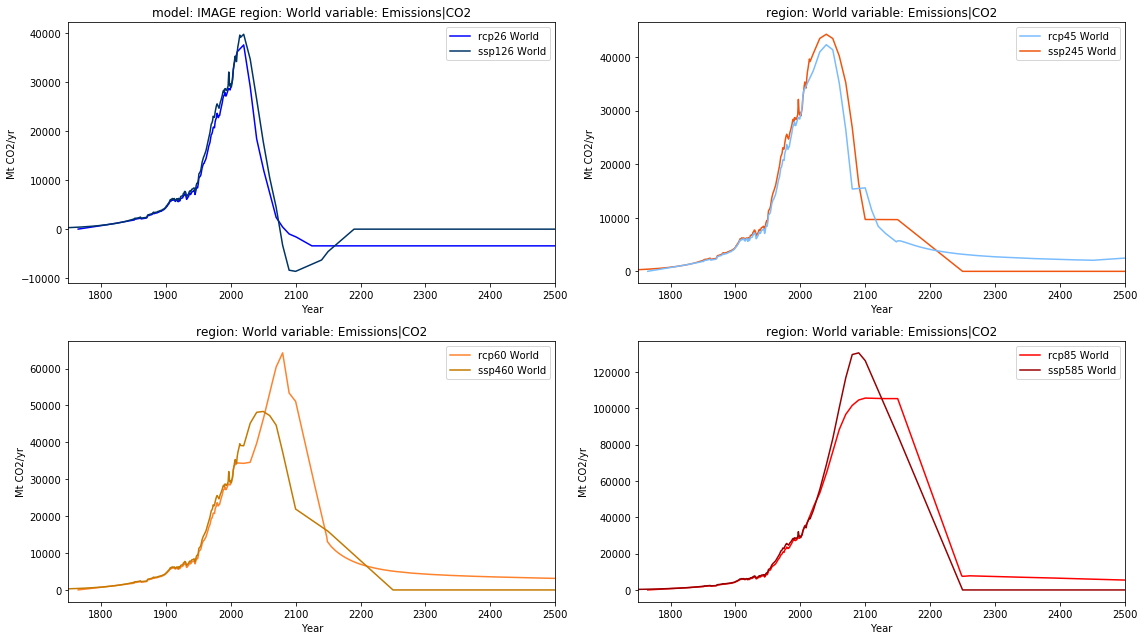

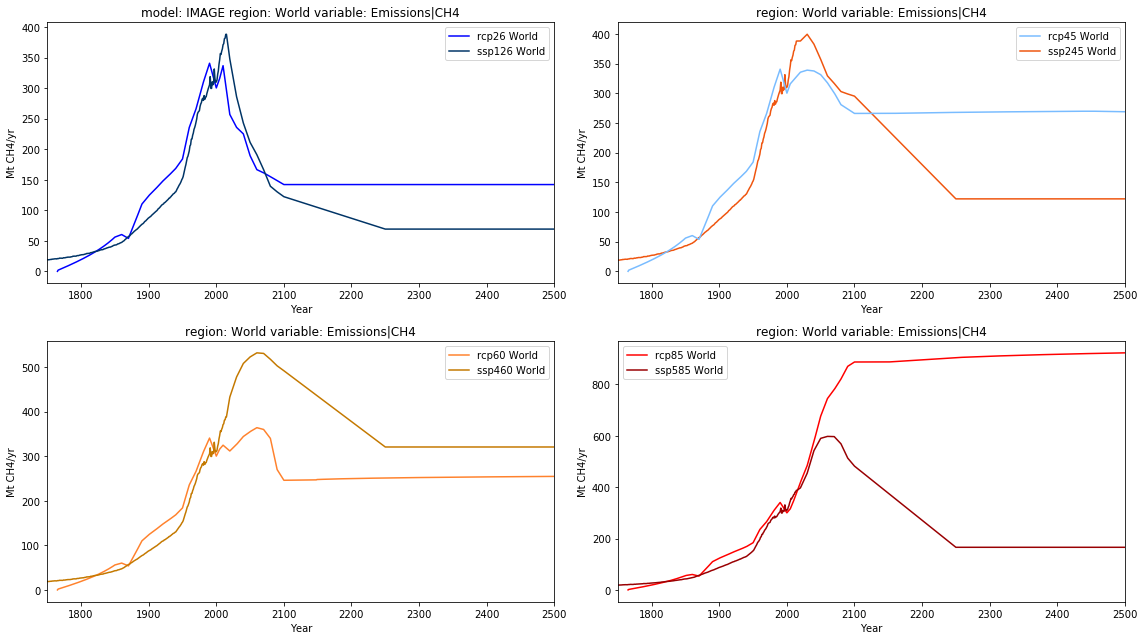

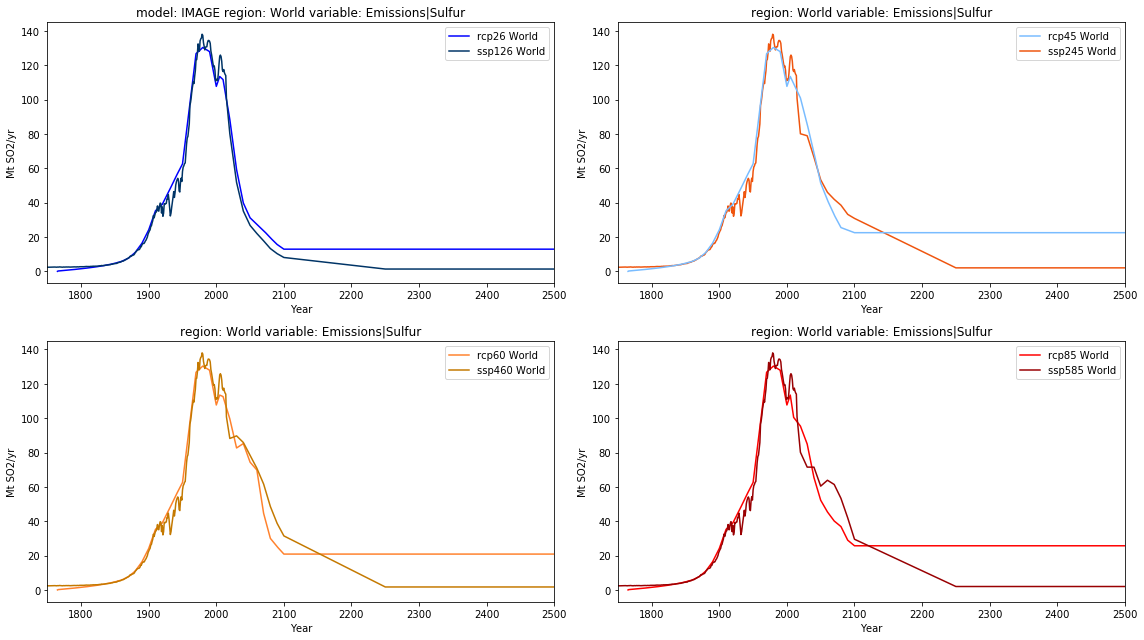

<IPython.core.display.Javascript object>

In [22]:
filters_variables = [["Emissions|CO2"], ["Emissions|CH4"], ["Emissions|Sulfur"]]
filters_scenario = [
    ["rcp26", "ssp126"],
    ["rcp45", "ssp245"],
    ["rcp60", "ssp460"],
    ["rcp85", "ssp585"],
]
region = ["World"]

pdf_to_save = matplotlib.backends.backend_pdf.PdfPages(EMMS_COMPARISON_FIGURE_PDF)

for filter_var in tqdm.tqdm_notebook(filters_variables, desc="Variable"):
    fig = plt.figure(figsize=(16, 9))
    axes = [
        fig.add_subplot(221),
        fig.add_subplot(222),
        fig.add_subplot(223),
        fig.add_subplot(224),
    ]
    for filter_scen, ax in tqdm.tqdm_notebook(zip(filters_scenario, axes), leave=False):
        pdf = db_protocol.filter(
            variable=filter_var, region=region, scenario=filter_scen
        )

        pdf = pdf.timeseries()
        pdf.columns = pdf.columns.map(lambda x: x.year)
        ax = pyam.IamDataFrame(pdf).line_plot(
            color="scenario", linestyle="region", ax=ax, legend=True
        )

    plt.tight_layout()
    pdf_to_save.savefig(fig)

pdf_to_save.close()

In [23]:
db = aggregate_effective_aerosol_forcing(db)
db.filter(variable="*Aerosols")["variable"].unique()

/Users/znicholls/Documents/AGCEC/RCMIP/rcmip/notebooks/results/phase-1/utils.py:61: UserWarning: No Effective Radiative Forcing|Anthropogenic|Aerosols data for FaIR-1.5*
  warnings.warn("No {} data for {}".format(var_to_agg, cm))
/Users/znicholls/Documents/AGCEC/RCMIP/rcmip/notebooks/results/phase-1/utils.py:61: UserWarning: No Effective Radiative Forcing|Anthropogenic|Aerosols data for OSCARv3.0
  warnings.warn("No {} data for {}".format(var_to_agg, cm))
/Users/znicholls/Documents/AGCEC/RCMIP/rcmip/notebooks/results/phase-1/utils.py:61: UserWarning: No Effective Radiative Forcing|Anthropogenic|Aerosols data for WASP,2,PROB*
  warnings.warn("No {} data for {}".format(var_to_agg, cm))
/Users/znicholls/Documents/AGCEC/RCMIP/rcmip/notebooks/results/phase-1/utils.py:67: UserWarning: No ['Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions', 'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-cloud Interactions'] data for MAGICC7.1.0.beta*
  warnings.

array(['Effective Radiative Forcing|Anthropogenic|Aerosols'], dtype=object)

<IPython.core.display.Javascript object>

In [24]:
db["variable"].unique()

array(['Effective Radiative Forcing|Anthropogenic|CO2',
       'Surface Air Temperature Change', 'Effective Radiative Forcing',
       'Effective Radiative Forcing|17th quantile',
       'Effective Radiative Forcing|33th quantile',
       'Effective Radiative Forcing|50th quantile',
       'Effective Radiative Forcing|67th quantile',
       'Effective Radiative Forcing|83th quantile',
       'Effective Radiative Forcing|Anthropogenic|Aerosols',
       'Surface Air Temperature Change|17th quantile',
       'Surface Air Temperature Change|33th quantile',
       'Surface Air Temperature Change|50th quantile',
       'Surface Air Temperature Change|67th quantile',
       'Surface Air Temperature Change|83th quantile',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-cloud Interactions',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|BC 

<IPython.core.display.Javascript object>

In [25]:
matplotlib.rcParams["figure.figsize"] = (6, 8)
matplotlib.rcParams["font.size"] = 6

<IPython.core.display.Javascript object>

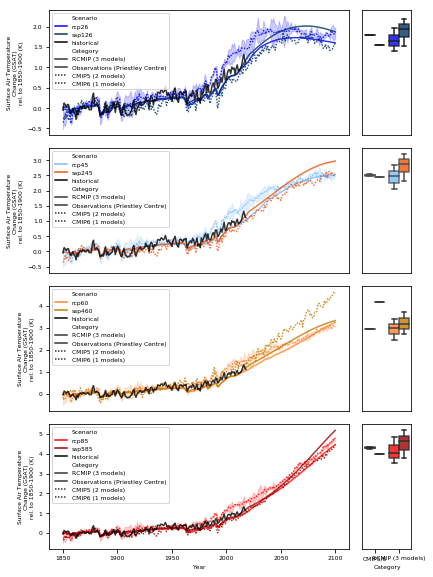

<IPython.core.display.Javascript object>

In [26]:
filters_variables = [
    ["Surface Air Temperature Change", "Surface Air Temperature Change|50*"]
]
ylabels = ["Surface Air Temperature\nChange (GSAT)"]
legend_locs = ["upper left", "upper left", "upper left", "lower left"]
filters_scenario = [
    ["rcp26", "ssp126"],
    ["rcp45", "ssp245"],
    ["rcp60", "ssp460"],
    ["rcp85", "ssp585"],
]
region = "World"
ignore_climatemodels = [
    "MAGICC7.1.0.beta_*NORCPM1*",
    "MAGICC7.1.0.beta_*CNRM-CM6-1-HR*",
    "MAGICC7.1.0.beta_*MPI-ESM1-2-HR*",
]  # , "hector*-CALIB"]
broken_cmip5_climatemodel = [
    "HadGEM2-CC_r1i1p1",
    "HadGEM2-CC_r2i1p1",
    "HadGEM2-CC_r3i1p1",
]

ref_period = (1850, 1900)
# ref_period = (1995, 2014)

plotting_dfs = {}

for filters_variable, ylabel_base, legend_loc in zip(
    filters_variables, ylabels, legend_locs
):
    fig = plt.figure()
    spec = gridspec.GridSpec(ncols=6, nrows=4, figure=fig)
    axes = [fig.add_subplot(spec[0, :5])]
    axes += [fig.add_subplot(spec[i, :5], sharex=axes[0]) for i in range(1, 4)]
    axes_bars = [fig.add_subplot(spec[0, 5], sharey=axes[0])]
    axes_bars += [
        fig.add_subplot(spec[i, 5], sharey=axes[i], sharex=axes_bars[0])
        for i in range(1, 4)
    ]
    plotting_dfs[ylabel_base] = []
    for i, (filter_scen, ax, ax_bar) in tqdm.tqdm_notebook(
        enumerate(zip(filters_scenario, axes, axes_bars)), leave=False
    ):
        sns_df = []
        sns_df_bar = []

        pdf = db.filter(
            variable=filters_variable,
            region=region,
            scenario=filter_scen,
            year=range(1850, 2101),
        )
        units = pdf.get_unique_meta("unit", no_duplicates=True)

        # only keep models which have done both runs
        pdf = pdf.filter(climatemodel=ignore_climatemodels, keep=False)
        rcp_climatemodels = set(pdf.filter(scenario=filter_scen[0])["climatemodel"])
        ssp_climatemodels = set(pdf.filter(scenario=filter_scen[1])["climatemodel"])
        rcp_ssp_climatemodels = rcp_climatemodels.intersection(ssp_climatemodels)
        pdf = pdf.filter(climatemodel=rcp_ssp_climatemodels)

        if "Temperature" in filters_variable[0]:
            pdf = pdf.relative_to_ref_period_mean(
                year=range(ref_period[0], ref_period[1] + 1)
            )
        else:
            pdf = pdf.timeseries()

        pdf.columns = pdf.columns.map(lambda x: x.year)
        pdf = pyam.IamDataFrame(pdf).data
        pdf["Category"] = "RCMIP ({} models)".format(len(pdf["climatemodel"].unique()))
        sns_df_bar.append(pdf)
        # ensure only median is plotted in the line plot for RCMIP data
        tmp = pdf.copy()
        pdf = (
            pdf.groupby(["scenario", "year", "Category", "unit", "region"])["value"]
            .median()
            .to_frame()
            .reset_index()
        )
        sns_df.append(pdf)

        pdf_obs = db_obs.filter(variable=filters_variable, region=region)
        if not pdf_obs.data.empty:
            if "Temperature" in filters_variable[0]:
                pdf_obs = convert_scmdf_to_pyamdf_year_only(
                    ScmDataFrame(
                        ScmDataFrame(pdf_obs).relative_to_ref_period_mean(
                            year=range(ref_period[0], ref_period[1] + 1)
                        )
                    )
                )

            pdf_obs = pdf_obs.data
            pdf_obs["Category"] = pdf_obs["climatemodel"]
            sns_df_bar.append(pdf_obs)
            sns_df.append(pdf_obs)

        pdf_cmip = db_cmip.filter(
            variable=filters_variable,
            region=region,
            scenario=filter_scen,
            year=range(1850, 2101),
        )
        if not pdf_cmip.timeseries().empty:
            if "Temperature" in filters_variable[0]:
                pdf_cmip = ScmDataFrame(
                    pdf_cmip.filter(
                        climatemodel=broken_cmip5_climatemodel, keep=False
                    ).relative_to_ref_period_mean(
                        year=range(ref_period[0], ref_period[1] + 1)
                    )
                )

            pdf_cmip = reduce_to_one_variant_per_model(
                convert_scmdf_to_pyamdf_year_only(pdf_cmip)
            )
            pdf_cmip = pdf_cmip.data
            no_models_cmip5 = len(
                pdf_cmip[pdf_cmip["mip_era"] == "CMIP5"]["climatemodel"].unique()
            )
            no_models_cmip6 = len(
                pdf_cmip[pdf_cmip["mip_era"] == "CMIP6"]["climatemodel"].unique()
            )
            pdf_cmip["Category"] = pdf_cmip["mip_era"].apply(
                lambda x: "{} ({} models)".format(
                    x, no_models_cmip5 if x == "CMIP5" else no_models_cmip6
                )
            )
            sns_df_bar.append(pdf_cmip)
            sns_df.append(pdf_cmip)

        sns_df = pd.concat(sns_df, axis=0, sort=False)
        sns_df_bar = pd.concat(sns_df_bar, axis=0, sort=False)
        plotting_dfs[ylabel_base].append(sns_df)

        palette = {}
        for s in sns_df["scenario"].unique():
            if s == "historical":
                palette[s] = "black"
            else:
                palette[s] = color_map_scenarios_hex[s]

        dashes = {}
        for c in sns_df["Category"].unique():
            if c.startswith("Obs"):
                dashes[c] = ""
            elif c.startswith("CMIP"):
                dashes[c] = (1, 1)
            else:
                dashes[c] = ""

        sns_df["Scenario"] = sns_df["scenario"]
        sns.lineplot(
            data=sns_df,
            x="year",
            y="value",
            hue="Scenario",
            palette=palette,
            style="Category",
            dashes=dashes,
            estimator="median",
            ax=ax,
            linewidth=1.5,
            ci="sd",
            alpha=0.8,
        )
        #         clean_labels(
        #             ax, ignore=["Scenario", "Category"] + sns_df["Scenario"].unique().tolist()
        #         )
        ax.legend(loc=legend_loc)
        ax.set_title("")
        base_ylabel = "{} ({})".format(
            ylabel_base, units.replace("W/m^2", "W m$^{-2}$")
        )
        if "Temperature" in filters_variable[0]:
            ylabel = base_ylabel.replace(
                ylabel_base,
                "{}\nrel. to {}-{}".format(ylabel_base, ref_period[0], ref_period[1]),
            )
        else:
            ylabel = base_ylabel

        ax.set_ylabel(ylabel)

        bar_df = sns_df_bar[sns_df_bar["scenario"] != "historical"]

        def take_mean(subdf):
            start = 2081
            end = 2100
            ydf = subdf[(subdf["year"] >= start) & (subdf["year"] <= end)]

            return ydf["value"].mean()

        bar_df = bar_df.groupby(["scenario", "Category", "climatemodel"]).apply(
            take_mean
        )
        bar_df.name = "value"
        bar_df = bar_df.to_frame().reset_index()
        bar_df["Category"] = bar_df["Category"].apply(
            lambda x: "CMIP5/6" if x.startswith("CMIP") else x
        )

        sns.boxplot(
            data=bar_df,
            x="Category",
            y="value",
            hue="scenario",
            palette=palette,
            saturation=1,
            boxprops={"alpha": 0.8},
            ax=ax_bar,
        )

        ax_bar.tick_params(labelleft=False, left=False)
        ax_bar.set_ylabel("")
        ax_bar.get_legend().remove()

        if i == (len(filters_scenario) - 1):
            ax.set_xlabel("Year")
        else:
            ax.set_xlabel("")
            ax.tick_params(labelbottom=False, bottom=False)
            ax_bar.set_xlabel("")
            ax_bar.tick_params(labelbottom=False, bottom=False)
    #         break

    plt.tight_layout()
    plt.show()

    fig.savefig("rcp_ssp_comparison_x_chapter_box.pdf")
    plotting_dfs[ylabel_base] = pd.concat(plotting_dfs[ylabel_base], sort=False)

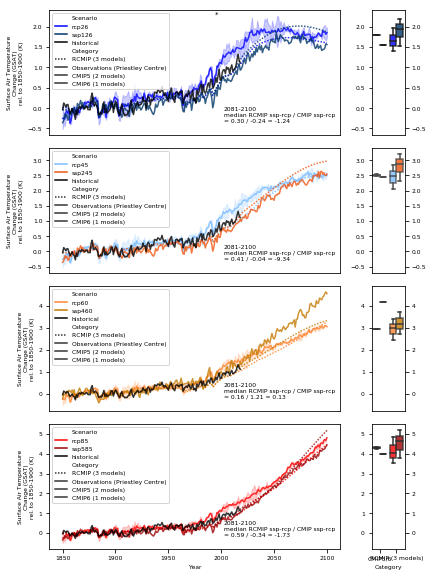

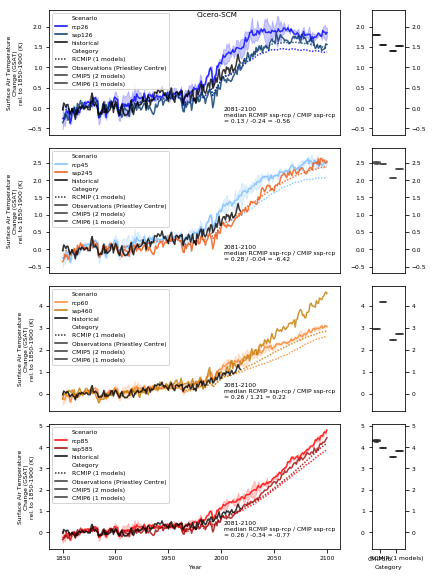

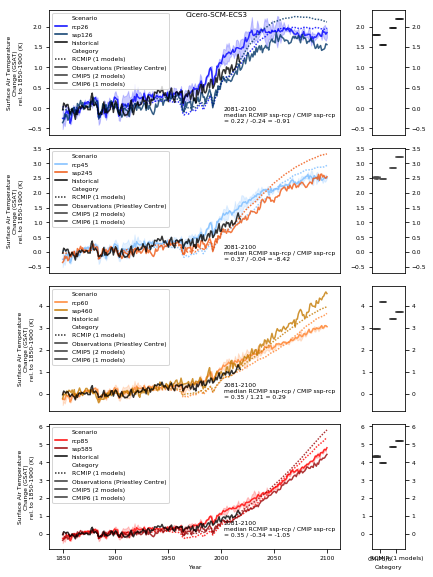

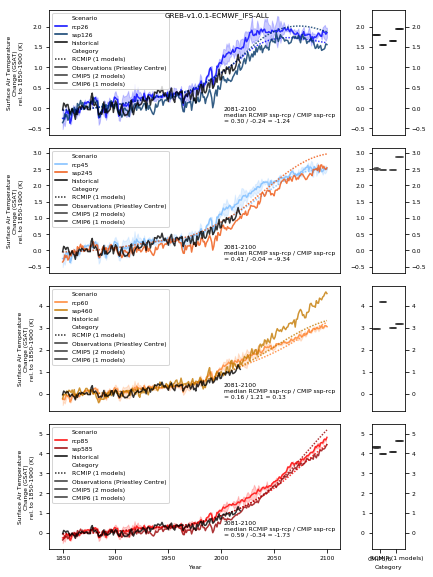

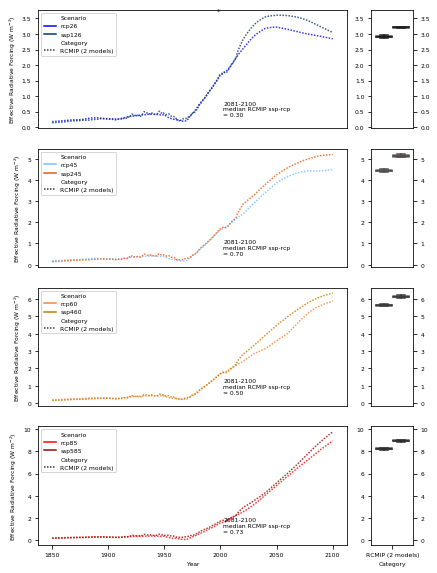

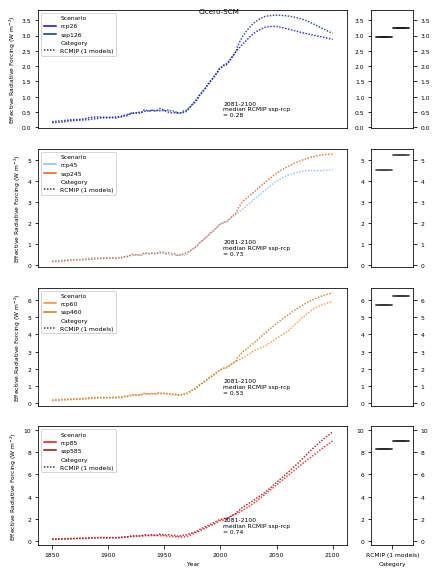

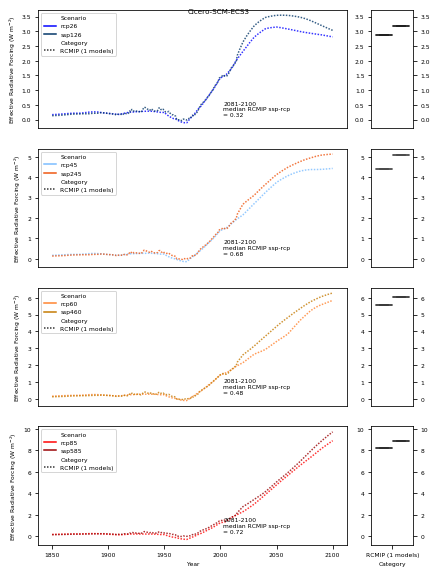

No data for GREB-v1.0.1-ECMWF_IFS-ALL
No data for GREB-v1.0.1-ECMWF_IFS-ALL
No data for GREB-v1.0.1-ECMWF_IFS-ALL
No data for GREB-v1.0.1-ECMWF_IFS-ALL


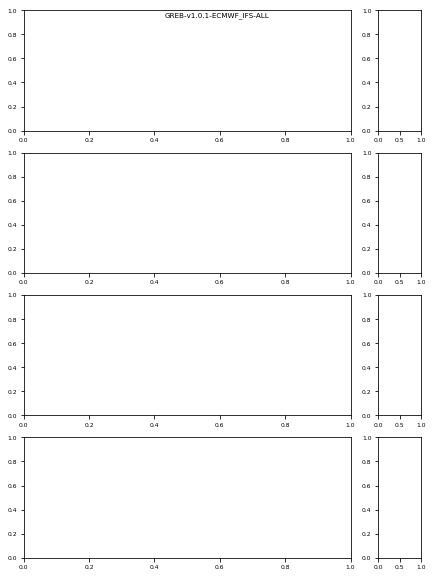

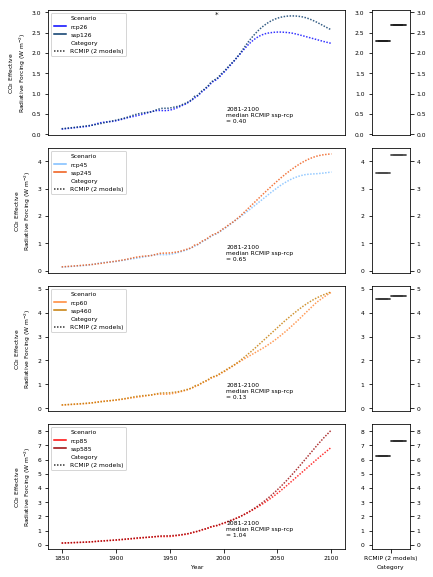

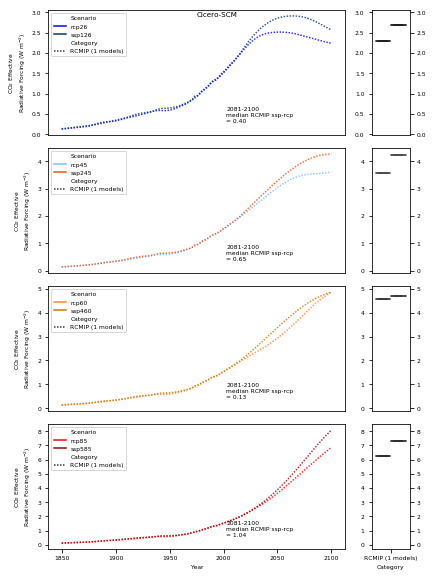

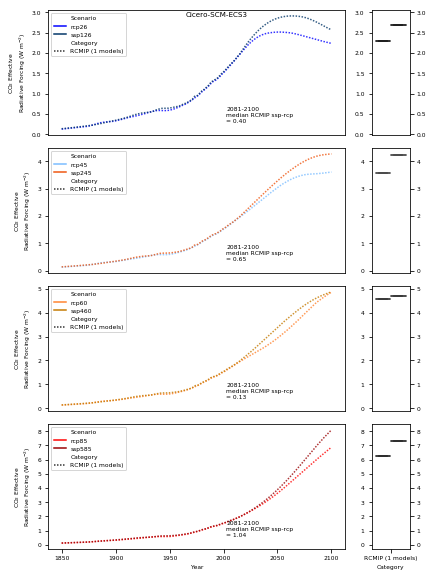

No data for GREB-v1.0.1-ECMWF_IFS-ALL
No data for GREB-v1.0.1-ECMWF_IFS-ALL
No data for GREB-v1.0.1-ECMWF_IFS-ALL
No data for GREB-v1.0.1-ECMWF_IFS-ALL


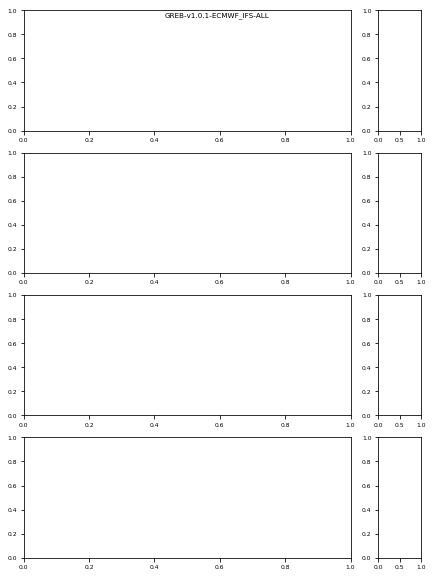

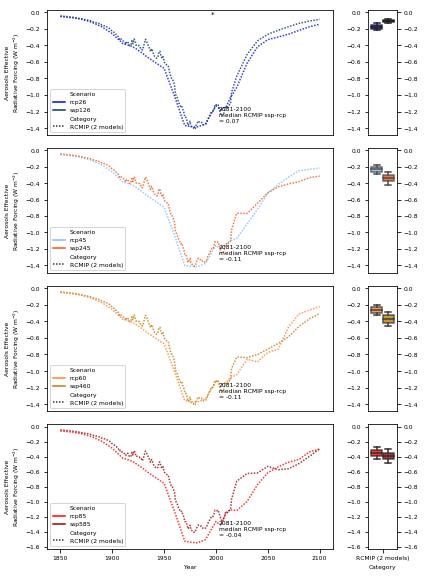

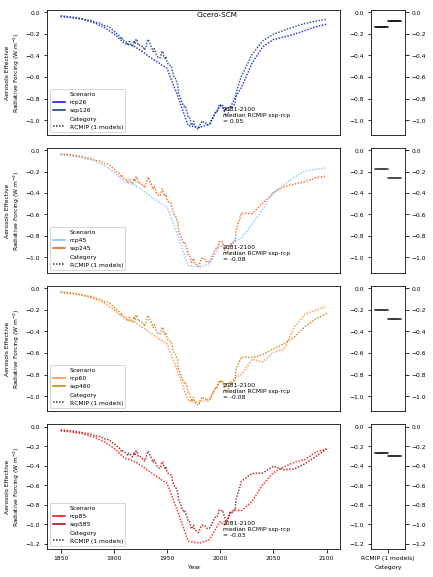

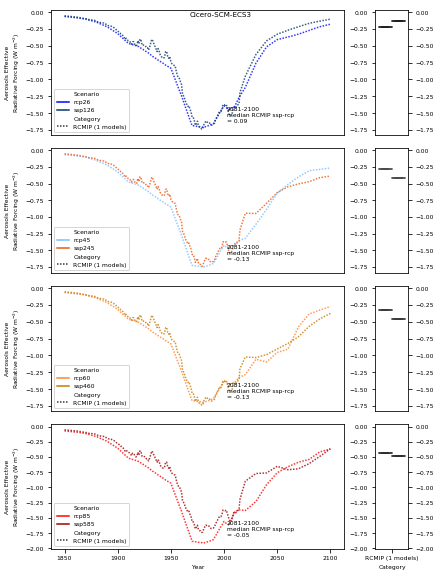

No data for GREB-v1.0.1-ECMWF_IFS-ALL
No data for GREB-v1.0.1-ECMWF_IFS-ALL
No data for GREB-v1.0.1-ECMWF_IFS-ALL
No data for GREB-v1.0.1-ECMWF_IFS-ALL


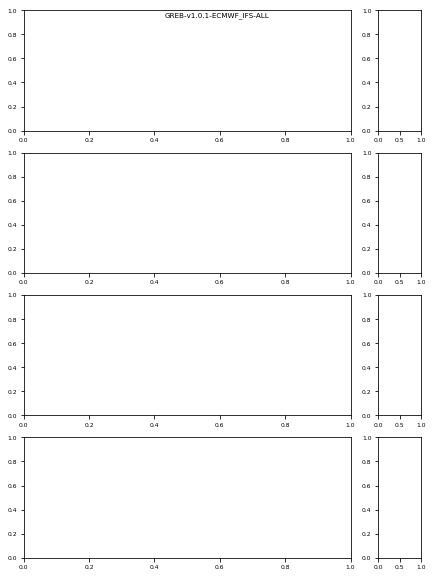

<IPython.core.display.Javascript object>

In [27]:
filters_variables = [
    ["Surface Air Temperature Change", "Surface Air Temperature Change|50*"],
    ["Effective Radiative Forcing", "Effective Radiative Forcing|50*"],
    [
        "Effective Radiative Forcing|Anthropogenic|CO2",
        "Effective Radiative Forcing|Anthropogenic|CO2|50*",
    ],
    [
        "Effective Radiative Forcing|Anthropogenic|Aerosols",
        "Effective Radiative Forcing|Anthropogenic|Aerosols|50*",
    ],
]
ylabels = [
    "Surface Air Temperature\nChange (GSAT)",
    "Effective Radiative Forcing",
    "CO$_2$ Effective\nRadiative Forcing",
    "Aerosols Effective\nRadiative Forcing",
]
legend_locs = ["upper left", "upper left", "upper left", "lower left"]
filters_scenario = [
    ["rcp26", "ssp126"],
    ["rcp45", "ssp245"],
    ["rcp60", "ssp460"],
    ["rcp85", "ssp585"],
]
region = "World"
ignore_climatemodels = [
    "MAGICC7.1.0.beta_*NORCPM1*",
    "MAGICC7.1.0.beta_*CNRM-CM6-1-HR*",
    "MAGICC7.1.0.beta_*MPI-ESM1-2-HR*",
]  # , "hector*-CALIB"]
broken_cmip5_climatemodel = [
    "HadGEM2-CC_r1i1p1",
    "HadGEM2-CC_r2i1p1",
    "HadGEM2-CC_r3i1p1",
]

ref_period = (1850, 1900)
# ref_period = (1995, 2014)

plotting_dfs = {}

pdf_to_save = matplotlib.backends.backend_pdf.PdfPages(
    "rcp_ssp_comparison_rcmip_model_by_model.pdf"
)

for filters_variable, ylabel_base, legend_loc in zip(
    filters_variables, ylabels, legend_locs
):
    for cm in tqdm.tqdm_notebook(
        ["*"] + sorted(db.filter(scenario="rcp85")["climatemodel"].unique().tolist())
    ):
        db_cm = db.filter(climatemodel=cm)
        fig = plt.figure()
        spec = gridspec.GridSpec(ncols=6, nrows=4, figure=fig)
        axes = [fig.add_subplot(spec[0, :5])]
        axes += [fig.add_subplot(spec[i, :5], sharex=axes[0]) for i in range(1, 4)]
        axes_bars = [fig.add_subplot(spec[0, 5], sharey=axes[0])]
        axes_bars += [
            fig.add_subplot(spec[i, 5], sharey=axes[i], sharex=axes_bars[0])
            for i in range(1, 4)
        ]
        plotting_dfs[ylabel_base] = []
        for i, (filter_scen, ax, ax_bar) in tqdm.tqdm_notebook(
            enumerate(zip(filters_scenario, axes, axes_bars)), leave=False
        ):
            sns_df = []
            sns_df_bar = []

            pdf = db_cm.filter(
                variable=filters_variable,
                region=region,
                scenario=filter_scen,
                year=range(1850, 2101),
            )
            if pdf.timeseries().empty:
                print("No data for {}".format(cm))
                continue

            units = pdf.get_unique_meta("unit", no_duplicates=True)

            # only keep models which have done both runs
            pdf = pdf.filter(climatemodel=ignore_climatemodels, keep=False)
            if pdf.timeseries().empty:
                print("Ignoring data for {}".format(cm))
                continue

            rcp_climatemodels = set(pdf.filter(scenario=filter_scen[0])["climatemodel"])
            ssp_climatemodels = set(pdf.filter(scenario=filter_scen[1])["climatemodel"])
            rcp_ssp_climatemodels = rcp_climatemodels.intersection(ssp_climatemodels)
            if not rcp_ssp_climatemodels:
                print("{} did not do {}".format(cm, filter_scen))
                continue

            pdf = pdf.filter(climatemodel=rcp_ssp_climatemodels)

            if "Temperature" in filters_variable[0]:
                pdf = pdf.relative_to_ref_period_mean(
                    year=range(ref_period[0], ref_period[1] + 1)
                )
            else:
                pdf = pdf.timeseries()

            pdf.columns = pdf.columns.map(lambda x: x.year)
            pdf = pyam.IamDataFrame(pdf).data
            pdf["Category"] = "RCMIP ({} models)".format(
                len(pdf["climatemodel"].unique())
            )
            sns_df_bar.append(pdf)
            # ensure only median is plotted in the line plot for RCMIP data
            tmp = pdf.copy()
            pdf = (
                pdf.groupby(["scenario", "year", "Category", "unit", "region"])["value"]
                .median()
                .to_frame()
                .reset_index()
            )
            sns_df.append(pdf)

            pdf_obs = db_obs.filter(variable=filters_variable, region=region)
            if not pdf_obs.data.empty:
                if "Temperature" in filters_variable[0]:
                    pdf_obs = convert_scmdf_to_pyamdf_year_only(
                        ScmDataFrame(
                            ScmDataFrame(pdf_obs).relative_to_ref_period_mean(
                                year=range(ref_period[0], ref_period[1] + 1)
                            )
                        )
                    )

                pdf_obs = pdf_obs.data
                pdf_obs["Category"] = pdf_obs["climatemodel"]
                sns_df_bar.append(pdf_obs)
                sns_df.append(pdf_obs)

            pdf_cmip = db_cmip.filter(
                variable=filters_variable,
                region=region,
                scenario=filter_scen,
                year=range(1850, 2101),
            )
            if not pdf_cmip.timeseries().empty:
                if "Temperature" in filters_variable[0]:
                    pdf_cmip = ScmDataFrame(
                        pdf_cmip.filter(
                            climatemodel=broken_cmip5_climatemodel, keep=False
                        ).relative_to_ref_period_mean(
                            year=range(ref_period[0], ref_period[1] + 1)
                        )
                    )

                pdf_cmip = reduce_to_one_variant_per_model(
                    convert_scmdf_to_pyamdf_year_only(pdf_cmip)
                )
                pdf_cmip = pdf_cmip.data
                no_models_cmip5 = len(
                    pdf_cmip[pdf_cmip["mip_era"] == "CMIP5"]["climatemodel"].unique()
                )
                no_models_cmip6 = len(
                    pdf_cmip[pdf_cmip["mip_era"] == "CMIP6"]["climatemodel"].unique()
                )
                pdf_cmip["Category"] = pdf_cmip["mip_era"].apply(
                    lambda x: "{} ({} models)".format(
                        x, no_models_cmip5 if x == "CMIP5" else no_models_cmip6
                    )
                )
                sns_df_bar.append(pdf_cmip)
                sns_df.append(pdf_cmip)

            sns_df = pd.concat(sns_df, axis=0, sort=False)
            sns_df_bar = pd.concat(sns_df_bar, axis=0, sort=False)
            plotting_dfs[ylabel_base].append(sns_df)

            palette = {}
            for s in sns_df["scenario"].unique():
                if s == "historical":
                    palette[s] = "black"
                else:
                    palette[s] = color_map_scenarios_hex[s]

            dashes = {}
            for c in sns_df["Category"].unique():
                if c.startswith("Obs"):
                    dashes[c] = ""
                elif c.startswith("CMIP"):
                    dashes[c] = ""
                else:
                    dashes[c] = (1, 1)

            sns_df["Scenario"] = sns_df["scenario"]
            sns.lineplot(
                data=sns_df,
                x="year",
                y="value",
                hue="Scenario",
                palette=palette,
                style="Category",
                dashes=dashes,
                estimator="median",
                ax=ax,
                linewidth=1.5,
                ci="sd",
                alpha=0.8,
            )
            #         clean_labels(
            #             ax, ignore=["Scenario", "Category"] + sns_df["Scenario"].unique().tolist()
            #         )
            ax.legend(loc=legend_loc)
            ax.set_title("")
            base_ylabel = "{} ({})".format(
                ylabel_base, units.replace("W/m^2", "W m$^{-2}$")
            )
            if "Temperature" in filters_variable[0]:
                ylabel = base_ylabel.replace(
                    ylabel_base,
                    "{}\nrel. to {}-{}".format(
                        ylabel_base, ref_period[0], ref_period[1]
                    ),
                )
            else:
                ylabel = base_ylabel

            ax.set_ylabel(ylabel)

            bar_df = sns_df_bar[sns_df_bar["scenario"] != "historical"]

            start_mean = 2081
            end_mean = 2100

            def take_mean(subdf):
                ydf = subdf[(subdf["year"] >= start_mean) & (subdf["year"] <= end_mean)]

                return ydf["value"].mean()

            bar_df = bar_df.groupby(["scenario", "Category", "climatemodel"]).apply(
                take_mean
            )
            bar_df.name = "value"
            bar_df = bar_df.to_frame().reset_index()
            bar_df["Category"] = bar_df["Category"].apply(
                lambda x: "CMIP5/6" if x.startswith("CMIP") else x
            )

            sns.boxplot(
                data=bar_df,
                x="Category",
                y="value",
                hue="scenario",
                palette=palette,
                saturation=1,
                boxprops={"alpha": 0.8},
                ax=ax_bar,
            )

            ax.tick_params(labelleft=True, left=True)
            ax_bar.tick_params(labelleft=True, left=True, labelright=True, right=True)
            ax_bar.set_ylabel("")
            ax_bar.get_legend().remove()

            if i == (len(filters_scenario) - 1):
                ax.set_xlabel("Year")
            else:
                ax.set_xlabel("")
                ax.tick_params(labelbottom=False, bottom=False)
                ax_bar.set_xlabel("")
                ax_bar.tick_params(labelbottom=False, bottom=False)

            mean_period_medians = bar_df.groupby(["Category", "scenario"])[
                "value"
            ].median()
            ssp_row = mean_period_medians.index.get_level_values(
                "scenario"
            ).str.startswith("ssp")
            cmip_row = mean_period_medians.index.get_level_values(
                "Category"
            ).str.startswith("CMIP")
            rcmip_median_delta = (
                mean_period_medians[~cmip_row & ssp_row].values.squeeze()
                - mean_period_medians[~cmip_row & ~ssp_row].values.squeeze()
            )

            if isinstance(pdf_cmip, pd.DataFrame):
                cmip_median_delta = (
                    mean_period_medians[cmip_row & ssp_row].values.squeeze()
                    - mean_period_medians[cmip_row & ~ssp_row].values.squeeze()
                )
                ax.annotate(
                    "{}-{}\nmedian RCMIP ssp-rcp / CMIP ssp-rcp\n= {:.2f} / {:.2f} = {:.2f}".format(
                        start_mean,
                        end_mean,
                        rcmip_median_delta,
                        cmip_median_delta,
                        rcmip_median_delta / cmip_median_delta,
                    ),
                    (0.6, 0.1),
                    xycoords="axes fraction",
                )
            else:
                ax.annotate(
                    "{}-{}\nmedian RCMIP ssp-rcp \n= {:.2f}".format(
                        start_mean, end_mean, rcmip_median_delta
                    ),
                    (0.6, 0.1),
                    xycoords="axes fraction",
                )
        #             break

        fig.suptitle(cm)
        plt.tight_layout()
        pdf_to_save.savefig(fig)
        plt.show()
#         break
#     break
pdf_to_save.close()

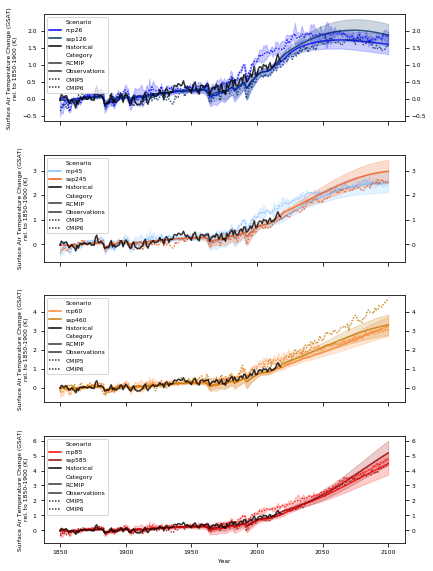

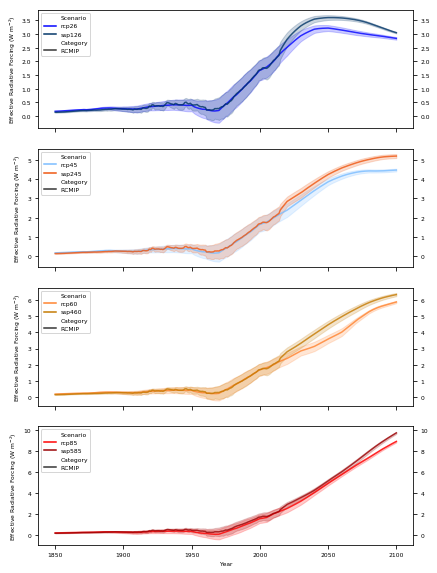

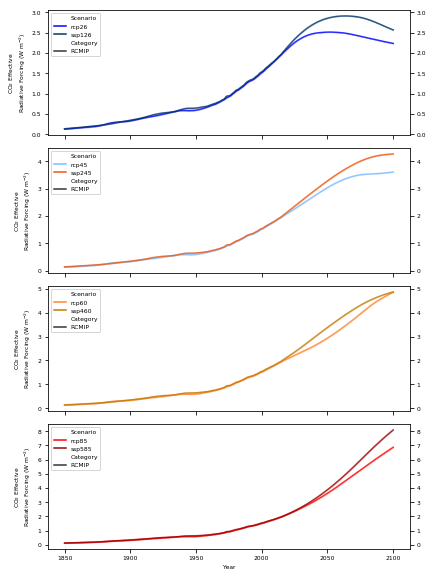

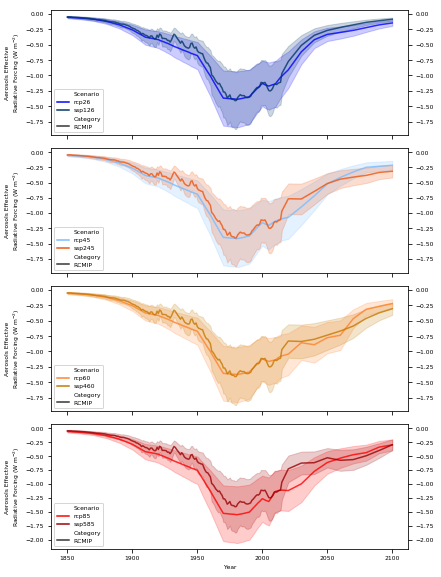

<IPython.core.display.Javascript object>

In [28]:
filters_variables = [
    ["Surface Air Temperature Change", "Surface Air Temperature Change|50*"],
    ["Effective Radiative Forcing", "Effective Radiative Forcing|50*"],
    [
        "Effective Radiative Forcing|Anthropogenic|CO2",
        "Effective Radiative Forcing|Anthropogenic|CO2|50*",
    ],
    [
        "Effective Radiative Forcing|Anthropogenic|Aerosols",
        "Effective Radiative Forcing|Anthropogenic|Aerosols|50*",
    ],
]
ylabels = [
    "Surface Air Temperature Change (GSAT)",
    "Effective Radiative Forcing",
    "CO$_2$ Effective\nRadiative Forcing",
    "Aerosols Effective\nRadiative Forcing",
]
legend_locs = ["upper left", "upper left", "upper left", "lower left"]
filters_scenario = [
    ["rcp26", "ssp126"],
    ["rcp45", "ssp245"],
    ["rcp60", "ssp460"],
    ["rcp85", "ssp585"],
]
region = "World"
ignore_climatemodels = [
    "MAGICC7.1.0.beta_*NORCPM1*",
    "MAGICC7.1.0.beta_*CNRM-CM6-1-HR*",
    "MAGICC7.1.0.beta_*MPI-ESM1-2-HR*",
]  # , "hector*-CALIB"]
broken_cmip5_climatemodel = [
    "HadGEM2-CC_r1i1p1",
    "HadGEM2-CC_r2i1p1",
    "HadGEM2-CC_r3i1p1",
]

ref_period = (1850, 1900)

pdf_to_save = matplotlib.backends.backend_pdf.PdfPages(TAS_COMPARISON_FIGURE_PDF)

plotting_dfs = {}

for filters_variable, ylabel_base, legend_loc in zip(
    filters_variables, ylabels, legend_locs
):
    fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True)
    axes = axes.flatten()
    plotting_dfs[ylabel_base] = []
    for filter_scen, ax in tqdm.tqdm_notebook(zip(filters_scenario, axes), leave=False):
        sns_df = []

        pdf = db.filter(
            variable=filters_variable,
            region=region,
            scenario=filter_scen,
            year=range(1850, 2101),
        )
        units = pdf.get_unique_meta("unit", no_duplicates=True)

        # only keep models which have done both runs
        pdf = pdf.filter(climatemodel=ignore_climatemodels, keep=False)
        rcp_climatemodels = set(pdf.filter(scenario=filter_scen[0])["climatemodel"])
        ssp_climatemodels = set(pdf.filter(scenario=filter_scen[1])["climatemodel"])
        rcp_ssp_climatemodels = rcp_climatemodels.intersection(ssp_climatemodels)
        pdf = pdf.filter(climatemodel=rcp_ssp_climatemodels)

        if "Temperature" in filters_variable[0]:
            pdf = pdf.relative_to_ref_period_mean(
                year=range(ref_period[0], ref_period[1] + 1)
            )
        else:
            pdf = pdf.timeseries()

        pdf.columns = pdf.columns.map(lambda x: x.year)
        pdf = pyam.IamDataFrame(pdf).data
        pdf["Category"] = "RCMIP"
        sns_df.append(pdf)

        pdf_obs = db_obs.filter(variable=filters_variable, region=region)
        if not pdf_obs.data.empty:
            if "Temperature" in filters_variable[0]:
                pdf_obs = convert_scmdf_to_pyamdf_year_only(
                    ScmDataFrame(
                        ScmDataFrame(pdf_obs).relative_to_ref_period_mean(
                            year=range(ref_period[0], ref_period[1] + 1)
                        )
                    )
                )

            pdf_obs = pdf_obs.data
            pdf_obs["Category"] = pdf_obs["climatemodel"]
            sns_df.append(pdf_obs)

        pdf_cmip = db_cmip.filter(
            variable=filters_variable,
            region=region,
            scenario=filter_scen,
            year=range(1850, 2101),
        )
        if not pdf_cmip.timeseries().empty:
            if "Temperature" in filters_variable[0]:
                pdf_cmip = ScmDataFrame(
                    pdf_cmip.filter(
                        climatemodel=broken_cmip5_climatemodel, keep=False
                    ).relative_to_ref_period_mean(
                        year=range(ref_period[0], ref_period[1] + 1)
                    )
                )

            pdf_cmip = reduce_to_one_variant_per_model(
                convert_scmdf_to_pyamdf_year_only(pdf_cmip)
            )
            pdf_cmip = pdf_cmip.data
            pdf_cmip["Category"] = pdf_cmip["mip_era"]
            sns_df.append(pdf_cmip)

        sns_df = pd.concat(sns_df, axis=0, sort=False)
        plotting_dfs[ylabel_base].append(sns_df)

        palette = {}
        for s in sns_df["scenario"].unique():
            if s == "historical":
                palette[s] = "black"
            else:
                palette[s] = color_map_scenarios_hex[s]

        dashes = {
            "Observations (Priestley Centre)": "",
            "RCMIP": "",  # (1, 1),
            "CMIP5": (1, 1),  # (4, 3, 1, 3),  # "",
            "CMIP6": (1, 1),  # (4, 3),  # "",
        }

        sns_df["Scenario"] = sns_df["scenario"]
        sns.lineplot(
            data=sns_df,
            x="year",
            y="value",
            hue="Scenario",
            palette=palette,
            style="Category",
            dashes=dashes,
            estimator="median",
            ax=ax,
            linewidth=1.5,
            ci="sd",
            alpha=0.8,
        )
        clean_labels(
            ax, ignore=["Scenario", "Category"] + sns_df["Scenario"].unique().tolist()
        )
        ax.legend(loc=legend_loc)
        ax.set_title("")
        base_ylabel = "{} ({})".format(
            ylabel_base, units.replace("W/m^2", "W m$^{-2}$")
        )
        if "Temperature" in filters_variable[0]:
            ylabel = base_ylabel.replace(
                ylabel_base,
                "{}\nrel. to {}-{}".format(ylabel_base, ref_period[0], ref_period[1]),
            )
        else:
            ylabel = base_ylabel

        ax.set_ylabel(ylabel)
        ax.set_xlabel("Year")
        ax.tick_params(labelright=True, right=True)
    #         break

    plt.tight_layout()
    plt.show()

    fig.savefig(
        TAS_COMPARISON_FIGURE_PDF.replace(
            ".pdf",
            "-{}.pdf".format(
                ylabel_base.lower()
                .replace(" ", "-")
                .replace("\n", "-")
                .replace("$", "")
                .replace("(", "")
                .replace(")", "")
                .replace("|", "")
            ),
        )
    )
    pdf_to_save.savefig(fig)
    plotting_dfs[ylabel_base] = pd.concat(plotting_dfs[ylabel_base], sort=False)
#     break

pdf_to_save.close()

In [29]:
tmp = (
    plotting_dfs["Surface Air Temperature Change (GSAT)"]
    .dropna(axis=1)
    .groupby(["Category", "year", "scenario"])["value"]
    .median()
    #     .mean()
    .unstack("year")
    .T.loc[2080:2100]
    .mean()
    .reset_index()
)
tmp["scenario_pair"] = tmp["scenario"].apply(lambda x: x[-2:])
tmp = tmp.set_index(["Category", "scenario", "scenario_pair"])

ssp_sp = {"26": "1", "45": "2", "60": "4", "85": "5"}
diff_explained = []
for sp in ["26", "45", "60", "85"]:
    cmip5_val = tmp.loc["CMIP5", "rcp{}".format(sp), sp]
    cmip6_val = tmp.loc["CMIP6", "ssp{}{}".format(ssp_sp[sp], sp), sp]
    rcmip_rcp_val = tmp.loc["RCMIP", "rcp{}".format(sp), sp]
    rcmip_ssp_val = tmp.loc["RCMIP", "ssp{}{}".format(ssp_sp[sp], sp), sp]
    print(cmip5_val)
    print(cmip6_val)
    print(rcmip_rcp_val)
    print(rcmip_ssp_val)
    cmip_diff = (cmip6_val - cmip5_val).values.squeeze()
    rcmip_diff = (rcmip_ssp_val - rcmip_rcp_val).values.squeeze()
    print(f"CMIP diff: {cmip_diff}")
    print(f"RCMIP diff: {rcmip_diff}")
    de = 1 - (cmip_diff - rcmip_diff) / cmip_diff
    print(f"Difference explained by scenario change: {100*de:.2f} %")
    diff_explained.append(de)
    print()
    print()

print(
    "Average difference explained by scenario change: {:.2f} %".format(
        np.mean(diff_explained).squeeze() * 100
    )
)

0    1.79367
Name: (CMIP5, rcp26, 26), dtype: float64
0    1.558139
Name: (CMIP6, ssp126, 26), dtype: float64
0    1.648888
Name: (RCMIP, rcp26, 26), dtype: float64
0    1.949762
Name: (RCMIP, ssp126, 26), dtype: float64
CMIP diff: -0.23553038584033592
RCMIP diff: 0.3008741904761907
Difference explained by scenario change: -127.74 %


0    2.507772
Name: (CMIP5, rcp45, 45), dtype: float64
0    2.448695
Name: (CMIP6, ssp245, 45), dtype: float64
0    2.479239
Name: (RCMIP, rcp45, 45), dtype: float64
0    2.880863
Name: (RCMIP, ssp245, 45), dtype: float64
CMIP diff: -0.059077052507003014
RCMIP diff: 0.4016246666666672
Difference explained by scenario change: -679.83 %


0    2.937153
Name: (CMIP5, rcp60, 60), dtype: float64
0    4.1234
Name: (CMIP6, ssp460, 60), dtype: float64
0    2.987901
Name: (RCMIP, rcp60, 60), dtype: float64
0    3.154427
Name: (RCMIP, ssp460, 60), dtype: float64
CMIP diff: 1.1862464422829126
RCMIP diff: 0.16652514285714304
Difference explained by scenario change: 1

<IPython.core.display.Javascript object>